In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
# Cell 1: Import Module
import pandas as pd
import numpy as np
import librosa
import glob
import torch
import torch.nn as nn
import os
import random
from matplotlib import pyplot as plt 
import seaborn as sns
import timm
import pandas.api.types
import kaggle_metric_utilities
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import gc
from ast import literal_eval
from warnings import filterwarnings
from torch.cuda.amp import GradScaler, autocast  # New imports for mixed precision

filterwarnings("ignore")

In [20]:
# Cell 2: CONFIG
class Config:
    train_dir = "/kaggle/input/birdclef-2025/train_audio"
    seed = 42
    train_csv = "/kaggle/input/birdclef-2025/train.csv"
    sample_csv = "/kaggle/input/birdclef-2025/sample_submission.csv"
    test_soundscapes = "/kaggle/input/birdclef-2025/test_soundscapes"

    sr = int(32e3)
    num_classes = 206

    n_fft = 1024
    hop_length = 500

    n_mels = 128
    fmin = 50
    fmax = 160000
    power = 2

# Create directory for saving models
SAVE_DIR = "/kaggle/working/model_weights"
os.makedirs(SAVE_DIR, exist_ok=True)

In [22]:
# Cell 3: Helper FUNCTION
def set_seed(seed: int = Config.seed) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Set Seed: {seed}")

set_seed()

[INFO] Set Seed: 42


In [23]:
# Cell 4: Load training data
data_df = pd.read_csv(Config.train_csv)
print(f"Loaded {len(data_df)} training examples")

Loaded 28564 training examples


In [24]:
# Cell 5: Check for null values
print("Checking for null values:")
print(data_df.isnull().sum())

Checking for null values:
primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
dtype: int64


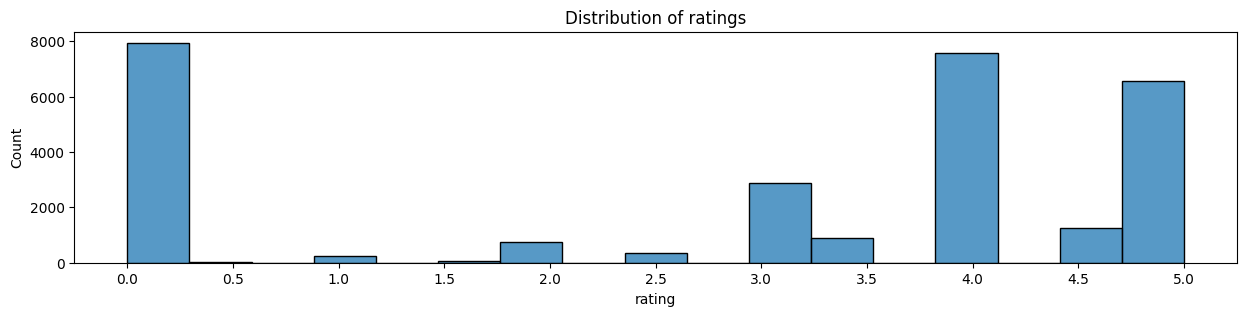

In [25]:
# Cell 6: Plot distribution of ratings
plt.figure(figsize=(15, 3))
sns.histplot(data_df, x='rating')
plt.xticks(np.arange(0, 5.5, 0.5))
plt.title("Distribution of ratings")
plt.show()

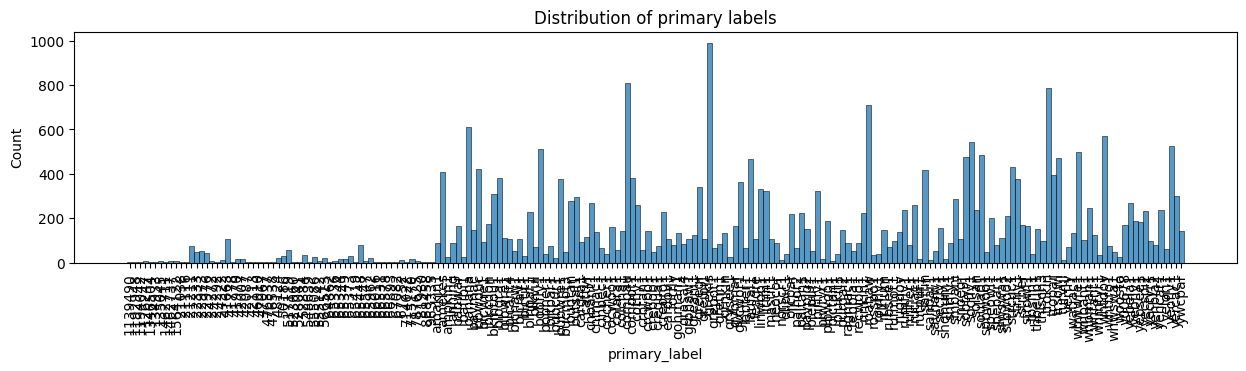

In [26]:
# Cell 7: Plot distribution of primary labels
plt.figure(figsize=(15, 3))
sns.histplot(data_df, x='primary_label')
plt.xticks(rotation=90)
plt.title("Distribution of primary labels")
plt.show()

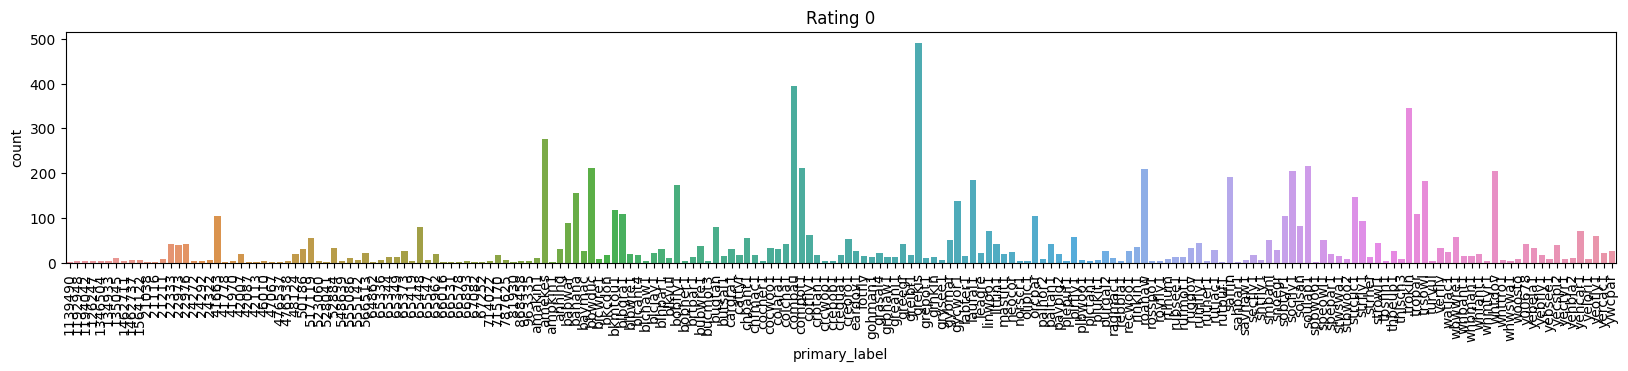

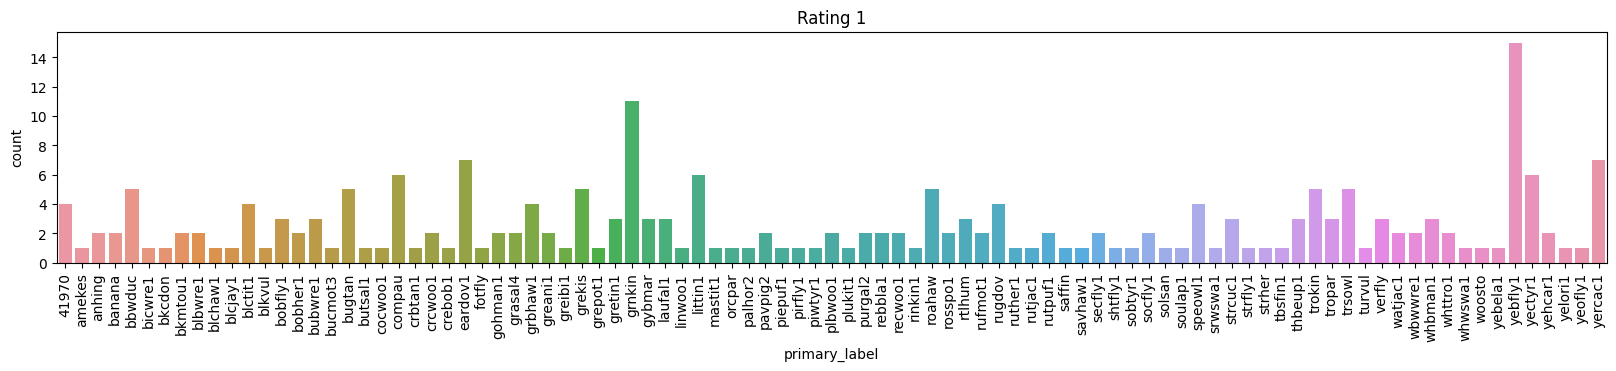

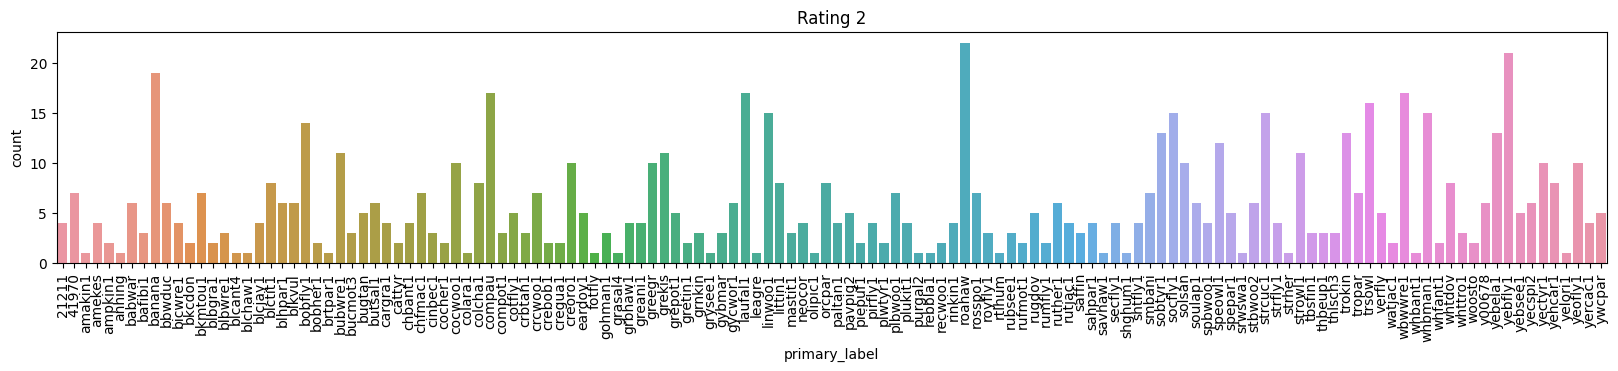

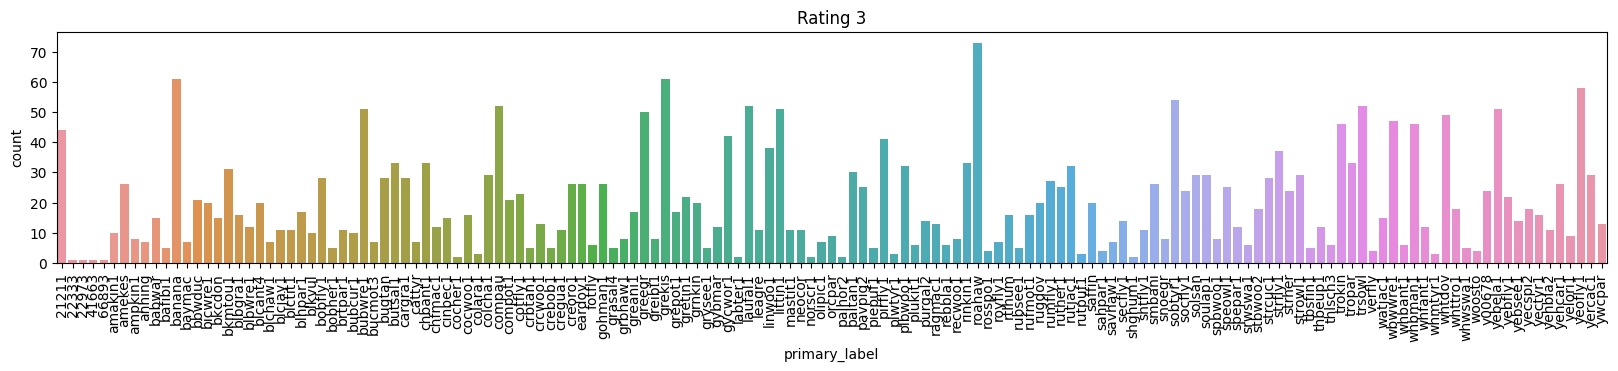

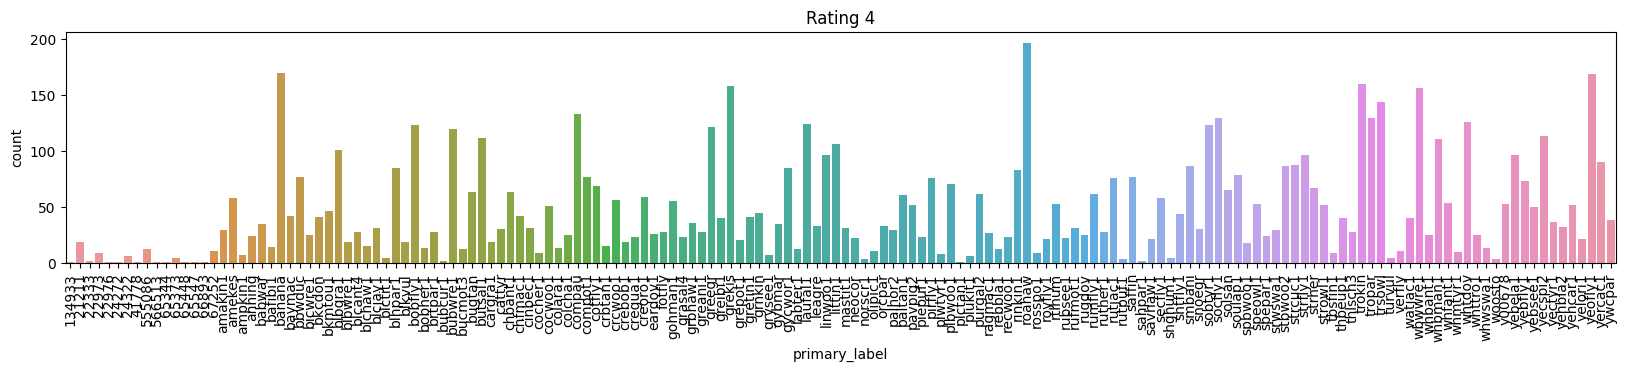

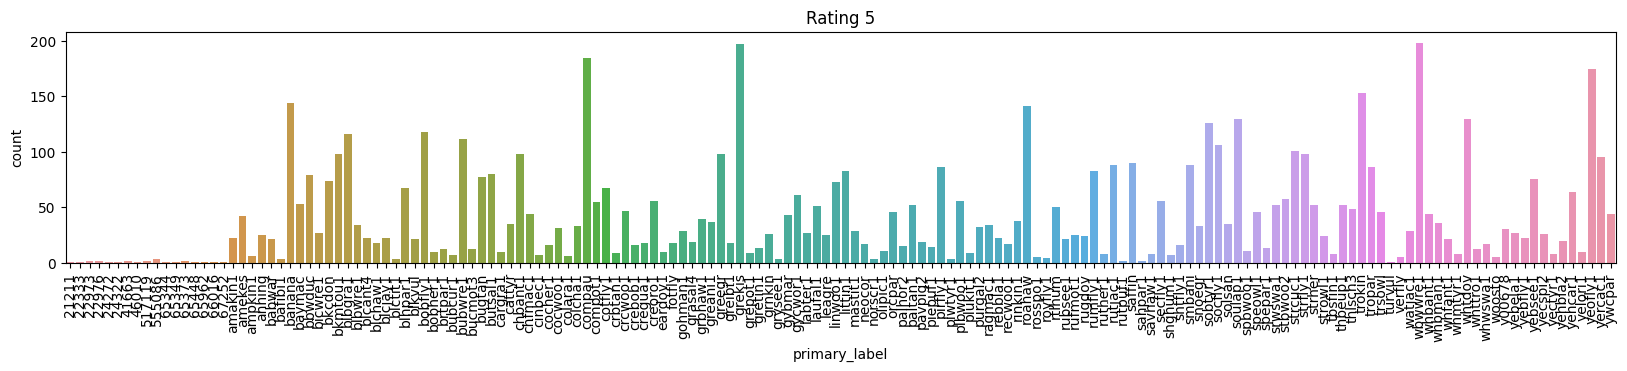

In [27]:
# Cell 8: Plot distribution of primary labels by rating
for r in range(0, 6):
    plt.figure(figsize=(20, 3))
    sns.countplot(data_df[data_df['rating']==float(r)], x='primary_label')
    plt.title(f"Rating {r}")
    plt.xticks(rotation=90)
    plt.show()

In [28]:
# Cell 9: Calculate audio durations
durations = []

for idx, row in data_df.sample(100).iterrows():
    try:
        data, _ = librosa.load(os.path.join(Config.train_dir, row['filename']), sr=Config.sr)
        durations.append(librosa.get_duration(y=data, sr=Config.sr))
    except Exception as e:
        print(f"Error loading {row['filename']}: {str(e)}")
        continue

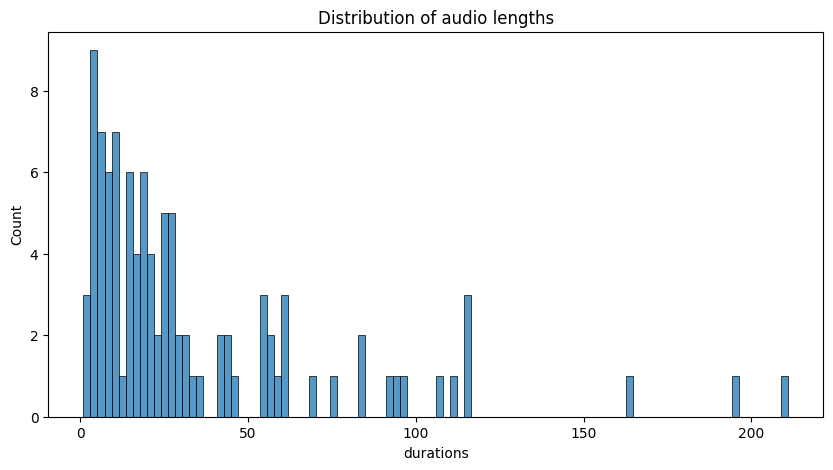

        durations
count  100.000000
mean    35.327839
std     40.285340
min      0.878750
25%      9.266945
50%     20.472750
75%     44.648250
max    210.901344


In [29]:
# Cell 10: Plot audio duration statistics
d_df = pd.DataFrame(columns=["durations"], data=durations)

plt.figure(figsize=(10, 5))
plt.title("Distribution of audio lengths")
sns.histplot(d_df, x="durations", bins=100)
plt.show()

print(d_df.describe())

In [30]:
# Cell 11: Function to show spectrograms
def show_signal(file_path):
    class_, collector = file_path.split("/")[-2:]

    y, sr = librosa.load(file_path, sr=Config.sr)

    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    fig.suptitle(f"Class: {class_} | Collector: {collector}", fontsize=16)

    # Plotting raw signal 
    librosa.display.waveshow(y, sr=sr, ax=axes[0, 0])
    axes[0, 0].set_title("Raw signal")
    
    # Plotting Fourier transformed signal
    ft = np.abs(librosa.stft(
        y,
        n_fft=Config.n_fft,
        hop_length=Config.hop_length
    ))
    im1 = librosa.display.specshow(
        ft,
        sr=sr,
        x_axis='time',
        y_axis='linear',
        ax=axes[0, 1]
    )
    fig.colorbar(im1, ax=axes[0, 1])
    axes[0, 1].set_title("Spectrogram")

    # Plotting log scaled Fourier transformed signal
    ft_db = librosa.amplitude_to_db(ft, ref=np.max)
    im2 = librosa.display.specshow(
        ft_db,
        sr=sr,
        x_axis='time',
        y_axis='log',
        ax=axes[1, 0]
    )
    fig.colorbar(im2, ax=axes[1, 0])
    axes[1, 0].set_title("Log Scaled spectrogram")

    # Plotting mel spectrogram
    mel_sp = librosa.feature.melspectrogram(
        y=y,
        sr=Config.sr,
        fmin=Config.fmin,
        fmax=Config.fmax,
        power=Config.power,
        n_mels=Config.n_mels,
    )
    mel_sp = librosa.power_to_db(mel_sp, ref=np.max)
    im3 = librosa.display.specshow(
        mel_sp,
        y_axis='mel',
        sr=Config.sr,
        fmin=Config.fmin,
        x_axis='time',
        fmax=Config.fmax,
        ax=axes[1, 1]
    )
    fig.colorbar(im3, ax=axes[1, 1])
    axes[1, 1].set_title("Mel Spectrogram")
    
    plt.show()


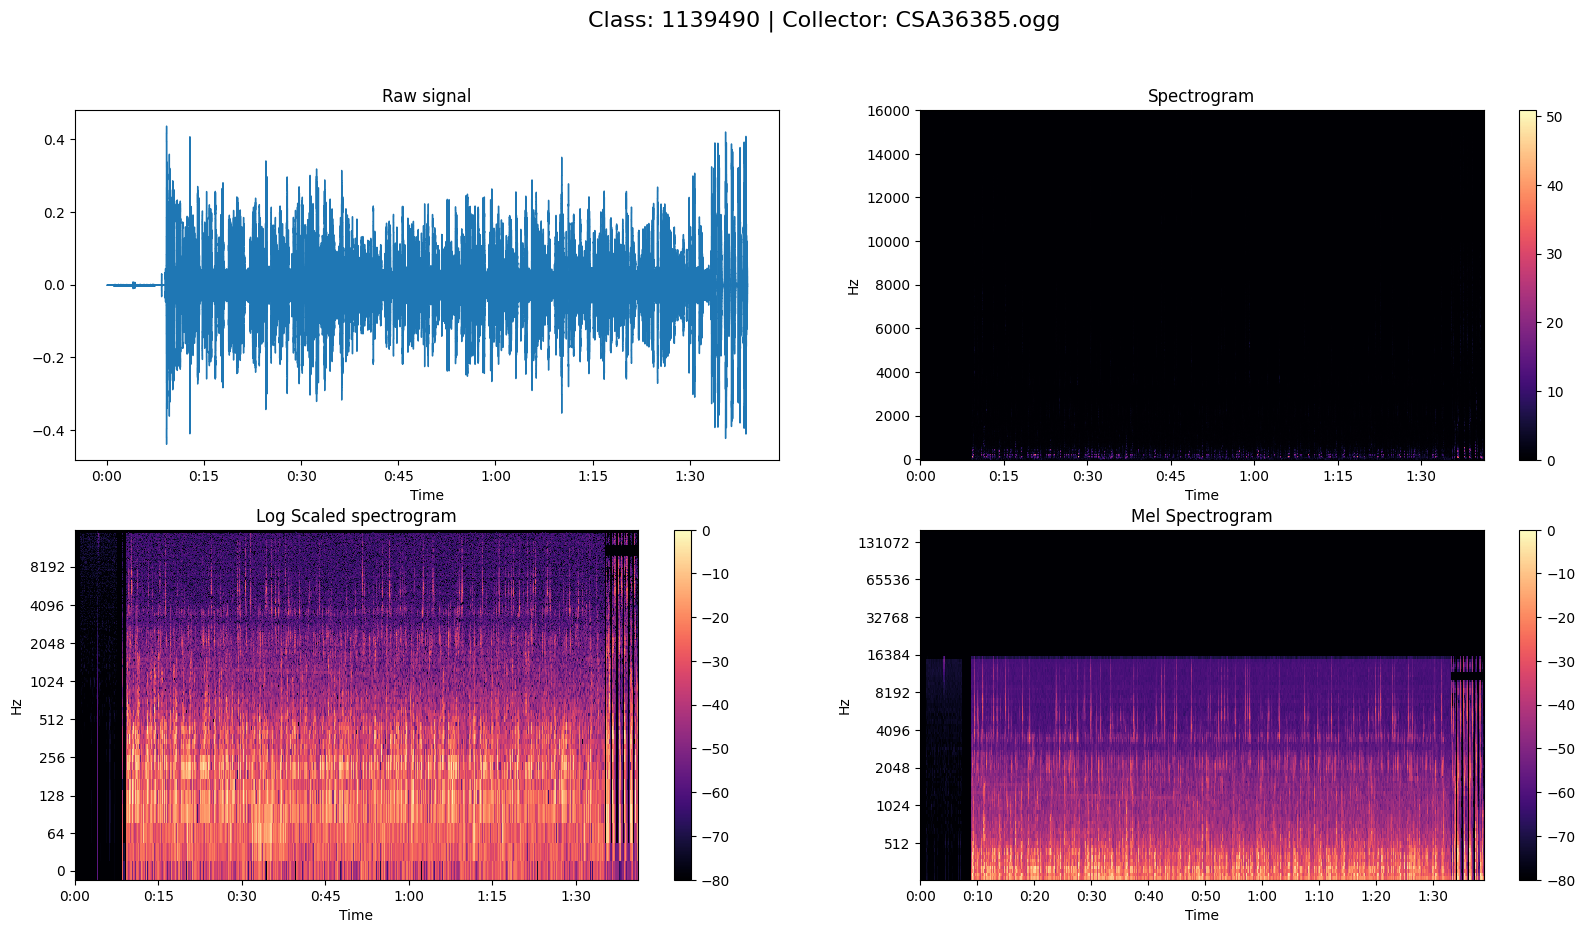

In [31]:
# Cell 12: Show spectrograms for sample data
show_signal(os.path.join(Config.train_dir, data_df['filename'].values[0]))

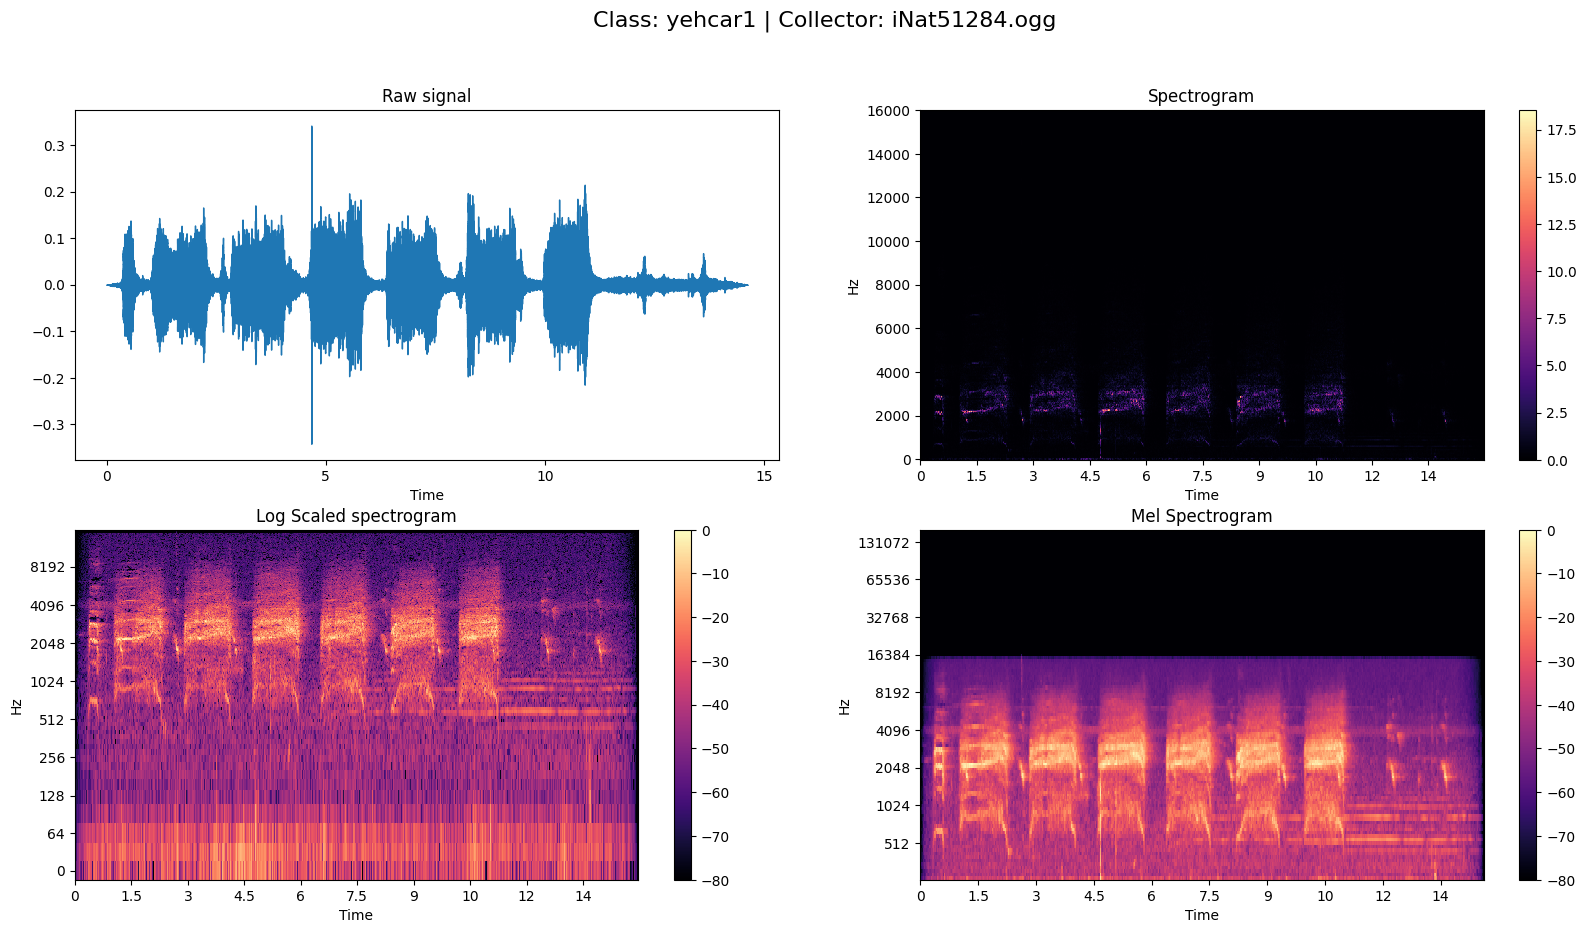

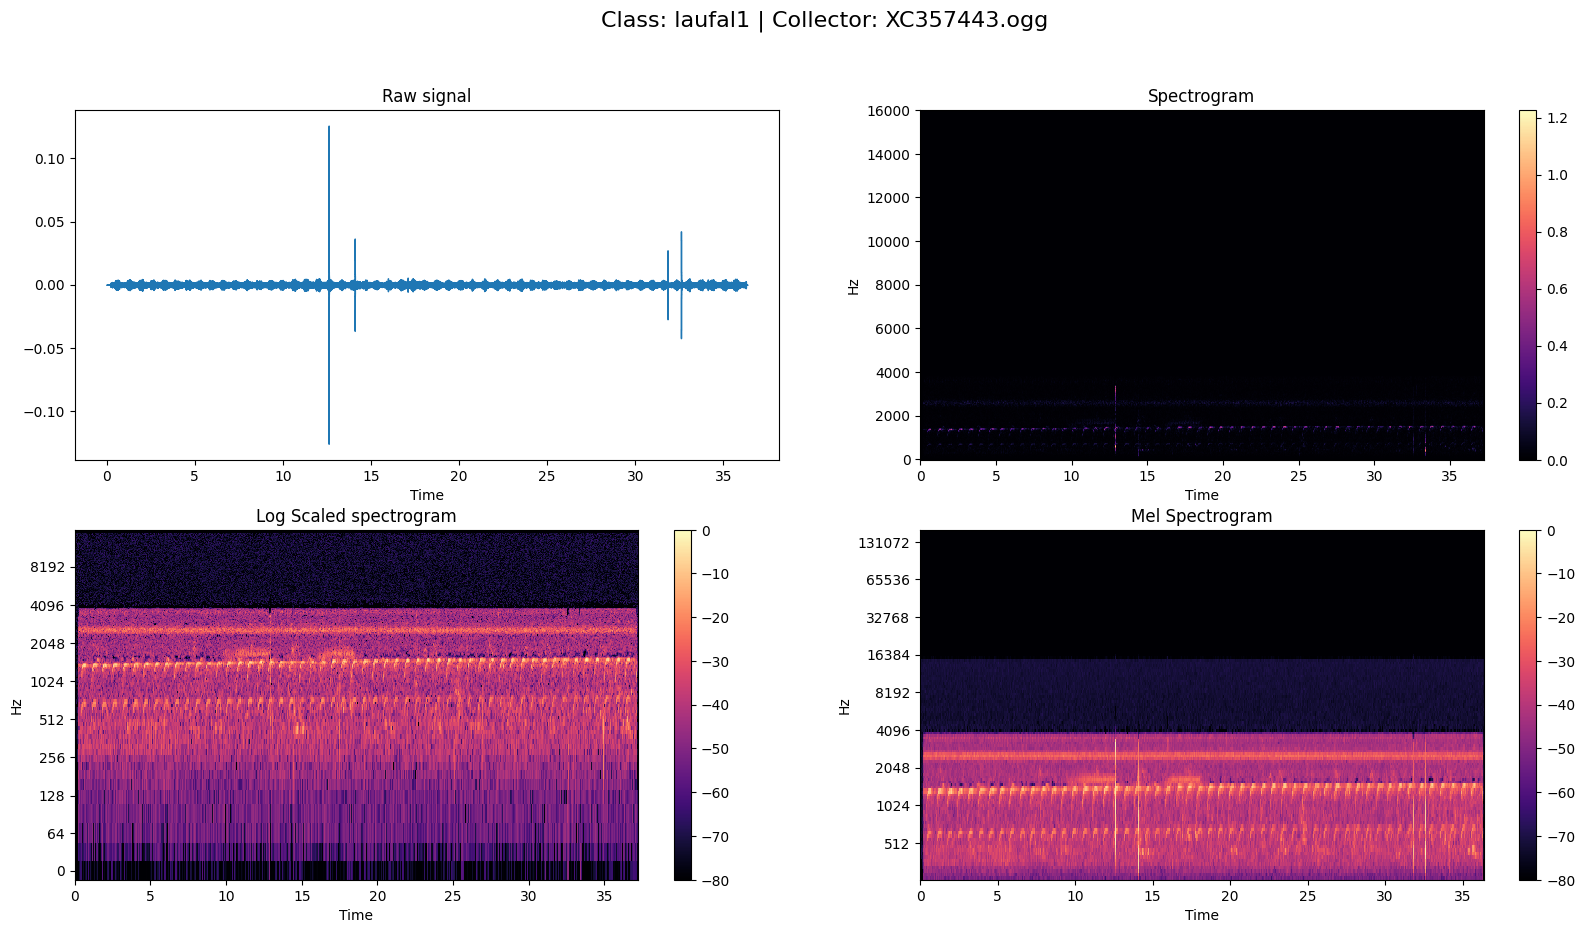

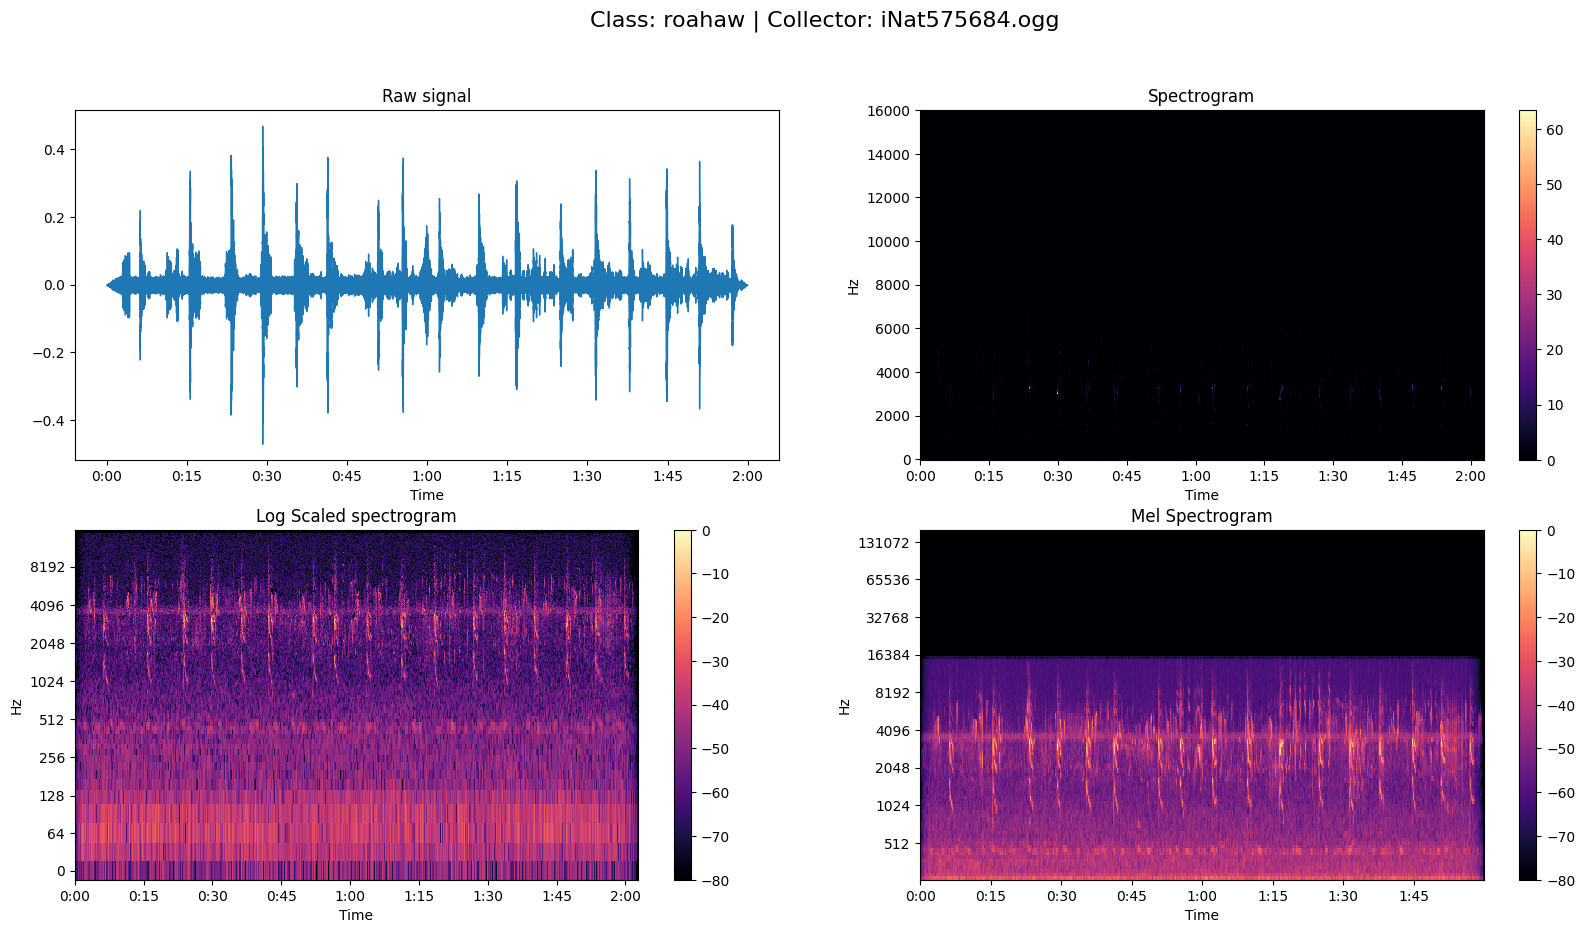

In [33]:
# Cell 13: Show more spectrograms
for idx, row in data_df.sample(3).iterrows():
    show_signal(os.path.join(Config.train_dir, row['filename']))

In [35]:
# Cell 14: Dataset preparation
label_mapper = {
    label: idx
    for idx, label in enumerate(sorted(data_df['primary_label'].unique()))
}

for_mapper = {
    idx: label
    for label, idx in label_mapper.items()
}

class BirdClefDataset(torch.utils.data.Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode

    def __len__(self):
        return len(self.df)
    
    def process(self, audio_path):
        try:
            data, _ = librosa.load(audio_path, sr=Config.sr)

            data = data * 1024
            chunk_duration = 10  # seconds
            min_len = chunk_duration * Config.sr

            # If the audio signal is less than min_len
            if len(data) < min_len:
                cnt = int(np.ceil(min_len / len(data)))
                data = np.tile(data, cnt)  # Fixed: np.title -> np.tile

            # Making the data length divisible by min_len
            leftover = len(data) % min_len
            if leftover > 0:
                front_crop = leftover // 2
                back_crop = leftover - front_crop
                data = data[front_crop: len(data) - back_crop]

            # Truncating the signal to min_len
            data = data[:min_len]
            data = data.reshape(-1, min_len)

            # Creating mel spectrogram
            mel_sp = librosa.feature.melspectrogram(
                y=data,
                sr=Config.sr,
                fmin=Config.fmin,
                fmax=Config.fmax,
                power=Config.power,
                n_mels=Config.n_mels,
                n_fft=Config.n_fft,
                hop_length=Config.hop_length
            )

            mel_sp = librosa.power_to_db(mel_sp, ref=1)

            # Normalizing the feature
            eps = 1e-12
            mel_sp = (mel_sp - mel_sp.min()) / (mel_sp.max() - mel_sp.min() + eps)

            mel_sp = mel_sp[:, :, :640]
            return mel_sp
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return a zero array in case of error
            return np.zeros((1, Config.n_mels, 640))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']
        
        # Make sure to handle paths correctly
        if self.mode == 'train':
            file_path = os.path.join(Config.train_dir, filename)
        else:
            file_path = filename  # For test mode, assume full path is provided
            
        x = self.process(file_path)

        if self.mode == 'train':
            y = label_mapper[row['primary_label']]
            return x, y

        return x

Mel spectrogram shape: (1, 128, 640)


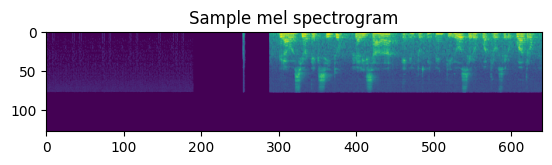

In [36]:
# Cell 15: Test the dataset
mel_sp = BirdClefDataset(data_df).process(os.path.join(Config.train_dir, data_df['filename'].values[0]))
print(f"Mel spectrogram shape: {mel_sp.shape}")

# Transform from C, H, W -> H, W, C
plt.imshow(mel_sp.reshape(128, 640, -1))
plt.title("Sample mel spectrogram")
plt.show()

In [38]:
# Cell 16: Model definition
class Model(nn.Module):
    def __init__(self, model_name="tf_efficientnet_b0"):
        super().__init__()
        self.base_model = timm.create_model(
            model_name=model_name,
            num_classes=Config.num_classes,
            pretrained=False,
            in_chans=1
        )

    def forward(self, x):
        return self.base_model(x)

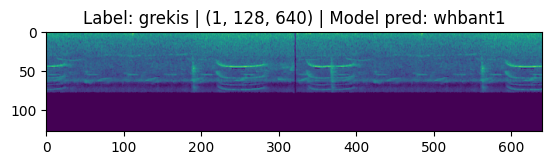

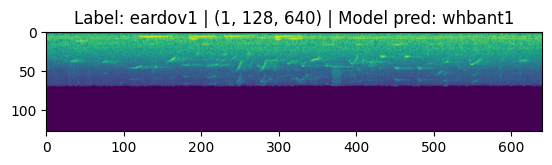

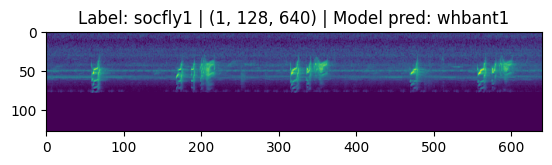

137318

In [39]:
# Cell 17: Verify dataset and model
tmp_ds = BirdClefDataset(data_df.sample(3).reset_index(drop=True))
model = Model("tf_efficientnet_b0")

for i in range(len(tmp_ds)):
    try:
        x, y = tmp_ds[i]

        model.eval()

        preds = model(torch.tensor([x]))
        preds = torch.argmax(torch.softmax(preds, dim=1), dim=1).item()
        plt.imshow(x.reshape(128, 640, -1))
        plt.title(f"Label: {for_mapper[y]} | {x.shape} | Model pred: {for_mapper[preds]}")
        plt.show()
    except Exception as e:
        print(f"Error processing sample {i}: {str(e)}")

del model
del tmp_ds
gc.collect()


In [40]:
# Cell 18: Training utilities
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return kaggle_metric_utilities.safe_call_score(sklearn.metrics.roc_auc_score, solution[scored_columns].values, submission[scored_columns].values, average='macro')

def cal_score(labels, preds):
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)

    labels_df = pd.DataFrame(labels > 0.5, columns=list(label_mapper.keys()))
    pred_df = pd.DataFrame(preds, columns=list(label_mapper.keys()))

    labels_df['id'] = np.arange(len(labels_df))
    pred_df['id'] = np.arange(len(pred_df))

    return score(labels_df, pred_df, row_id_column_name='id')

In [42]:
# Cell 19: Checkpointing functions
def save_checkpoint(model, optimizer, epoch, fold, auc_val, avg_val_loss, is_best=False):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'fold': fold,
        'auc_val': auc_val,
        'val_loss': avg_val_loss
    }
    
    # Save regular checkpoint
    checkpoint_path = f"{SAVE_DIR}/checkpoint_fold_{fold}_latest.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved checkpoint to {checkpoint_path}")
    
    # Save best model if needed
    if is_best:
        best_model_path = f"{SAVE_DIR}/best_model_fold_{fold}_auc_{auc_val:.4f}.pth"
        torch.save(checkpoint, best_model_path)
        print(f"Saved best model with AUC: {auc_val:.4f} to {best_model_path}")

def load_checkpoint(model, optimizer, fold):
    checkpoint_path = f"{SAVE_DIR}/checkpoint_fold_{fold}_latest.pth"
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_auc = checkpoint['auc_val']
        print(f"Resuming from epoch {start_epoch} with best AUC {best_auc:.4f}")
        return start_epoch, best_auc
    print(f"No checkpoint found at {checkpoint_path}, starting from scratch")
    return 0, 0

In [43]:
# Cell 20: Training configuration
epochs = 20
num_folds = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-4
target_col = 'primary_label'
df = data_df

print(f"Training configuration:")
print(f"- Device: {device}")
print(f"- Epochs: {epochs}")
print(f"- Learning rate: {lr}")
print(f"- Number of folds: {num_folds}")
print(f"- Classes: {Config.num_classes}")

Training configuration:
- Device: cuda
- Epochs: 20
- Learning rate: 0.0001
- Number of folds: 3
- Classes: 206


In [45]:
# Cell 21: Prepare folds
skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=Config.seed
)

df['KFold'] = -1

for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df[target_col])):
    df.loc[val_idx, 'KFold'] = fold

print(f"Fold distribution:")
print(df['KFold'].value_counts())

# Initialize mixed precision training
scaler = GradScaler()

Fold distribution:
KFold
0    9522
1    9521
2    9521
Name: count, dtype: int64


In [ ]:

# Cell 22: Training loop with all improvements
for fold in range(num_folds):
    print(f"\n{'='*50}")
    print(f"Starting training for fold {fold}")
    print(f"{'='*50}")
    
    train_df = df[df['KFold'] != fold].reset_index(drop=True)
    val_df = df[df['KFold'] == fold].reset_index(drop=True)
    
    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

    train_ds = BirdClefDataset(train_df)
    val_ds = BirdClefDataset(val_df)

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        drop_last=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_ds,
        batch_size=16,
        shuffle=False,
        num_workers=2,
        drop_last=False
    )

    # Initializing model
    model = Model("tf_efficientnet_b0").to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Try to load checkpoint
    start_epoch, best_auc = load_checkpoint(model, optimizer, fold)
    
    for epoch in range(start_epoch, epochs):
        print(f"\nStarting epoch {epoch} for fold {fold}")
        
        # Training phase
        model.train()
        pred_train = []
        label_train = []
        running_loss = 0.0

        for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
            x, y = x.to(device), y.to(device)

            # Converting to one hot encoding
            y_one_hot = nn.functional.one_hot(
                y,
                num_classes=Config.num_classes
            ).float()

            # Mixed precision training
            with autocast():
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
            
            # Scale gradients and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            
            # Batch-level checkpointing for very large datasets
            if batch_idx > 0 and batch_idx % 500 == 0:
                print(f"Completed {batch_idx}/{len(train_loader)} batches")
                if batch_idx % 1000 == 0:  # Less frequent cache clearing
                    torch.cuda.empty_cache()
                
            # Get predictions
            with torch.no_grad():
                probs = torch.softmax(outputs, dim=1)
                pred_train.append(probs.detach().cpu().numpy())
                label_train.append(y_one_hot.detach().cpu().numpy())

        # Validation phase
        model.eval()
        pred_val = []
        label_val = []
        running_val_loss = 0.0

        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
                x, y = x.to(device), y.to(device)

                # Converting to one hot encoding
                y_one_hot = nn.functional.one_hot(
                    y,
                    num_classes=Config.num_classes
                ).float()

                outputs = model(x)
                loss = criterion(outputs, y)
                running_val_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                pred_val.append(probs.detach().cpu().numpy())
                label_val.append(y_one_hot.detach().cpu().numpy())

        # Computing AUC and Loss with error handling
        try:
            auc_train = cal_score(label_train, pred_train)
            auc_val = cal_score(label_val, pred_val)
            
            avg_train_loss = running_loss / len(train_loader)
            avg_val_loss = running_val_loss / len(val_loader)

            print(f"[Fold]:{fold} | [EPOCH]:{epoch} | Loss: {avg_train_loss:.4f} | val_Loss: {avg_val_loss:.4f}")
            print(f"[Fold]:{fold} | [EPOCH]:{epoch} | Train AUC: {auc_train:.4f} | val_AUC: {auc_val:.4f}")
            
            # Save checkpoint for every epoch
            is_best = auc_val > best_auc
            if is_best:
                best_auc = auc_val
                print(f"New best AUC: {best_auc:.4f}")
                
            save_checkpoint(model, optimizer, epoch, fold, auc_val, avg_val_loss, is_best)
            
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            # Still save the checkpoint even if metrics fail
            save_checkpoint(model, optimizer, epoch, fold, 0, running_val_loss/len(val_loader), False)
        
        # Clear memory periodically
        if epoch % 3 == 0:
            print("Clearing CUDA cache")
            torch.cuda.empty_cache()
            gc.collect()

    print(f"Finished training fold {fold} with best AUC: {best_auc:.4f}")
    
    # Clean up before next fold
    del train_df, val_df, train_ds, val_ds, train_loader, val_loader, model, criterion, optimizer
    gc.collect()
    torch.cuda.empty_cache()

print("Training completed for all folds!")



Starting training for fold 0
Train size: 19042, Val size: 9522
No checkpoint found at /kaggle/working/model_weights/checkpoint_fold_0_latest.pth, starting from scratch

Starting epoch 0 for fold 0


Training Epoch 0:  21%|██        | 501/2380 [02:26<09:08,  3.42it/s]

Completed 500/2380 batches


Training Epoch 0:  42%|████▏     | 1001/2380 [04:46<05:52,  3.91it/s]

Completed 1000/2380 batches


Training Epoch 0:  63%|██████▎   | 1502/2380 [07:05<03:07,  4.69it/s]

Completed 1500/2380 batches


Training Epoch 0:  84%|████████▍ | 2001/2380 [09:20<01:48,  3.48it/s]

Completed 2000/2380 batches


Validation Epoch 0:  78%|███████▊  | 466/596 [03:53<01:05,  1.98it/s]